**Notebook to compare Akantu and WOBBLE for accelerating rotation about one axis**

In [1]:
import sys
sys.path.append('../..')

import numpy as np
import akantu as aka
from tqdm import tqdm
from wobble.rb_simple import SimpleRB
from wobble.rb_coupled import CoupledRB
from wobble.pure import PureMA
import matplotlib.pyplot as plt

In [2]:
# SimpleRB Simulation
sim=SimpleRB('Simple_RB', 3, 0.01, 1,
                 mesh_file='../sample_data_files/mesh_files/beam.msh',
                 material_file='../sample_data_files/material_files/steel.dat',
                 num_modes=10,
                 force_path='../sample_data_files/force_files/pure_rotation_100.txt',
                 eigenmode_path='../sample_data_files/eigenmode_files/rb_modes.csv')
sim.solve()

In [3]:
# CoupledRB Simulation
cup=CoupledRB('Double_RB', 3, 0.01, 1,
                 mesh_file='../sample_data_files/mesh_files/beam.msh',
                 material_file='../sample_data_files/material_files/steel.dat',
                 num_modes=10,
                 force_path='../sample_data_files/force_files/pure_rotation_100.txt',
                 eigenmode_path='../sample_data_files/eigenmode_files/rb_modes.csv')
cup.solve()

In [4]:
# Running the Akantu simulation
spatial_dimension = 3
mesh_file = '../sample_data_files/mesh_files/beam.msh'

aka.parseInput('../sample_data_files/material_files/steel.dat')
mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)

model.initFull(_analysis_method=aka._explicit_lumped_mass)

displacement = model.getDisplacement()
force = model.getExternalForce()

for row in range(force.shape[0]):
    force[row] = sim.unprojected_force[:, 0].reshape(-1, 3)[row]

time_factor = 0.8
stable_time_step = model.getStableTimeStep() * time_factor
model.setTimeStep(stable_time_step)
max_steps = int(1 / stable_time_step)


force_times = np.hstack((sim.force_times, 1e5))

disps=[]
j = 1
for i in tqdm(range(0, max_steps + 1)):
    
    if i * stable_time_step >= force_times[j]:
        for row in range(force.shape[0]):
            force[row] = sim.unprojected_force[:, j].reshape(-1, 3)[row]
            
        j += 1
    
    model.solveStep()
    if i % 1000 == 0:
        disp=model.getDisplacement()
        disps.append(disp.copy())

disps = np.array(disps)

100%|██████████| 115558/115558 [03:22<00:00, 571.07it/s]


In [5]:
# Plotting parameters
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

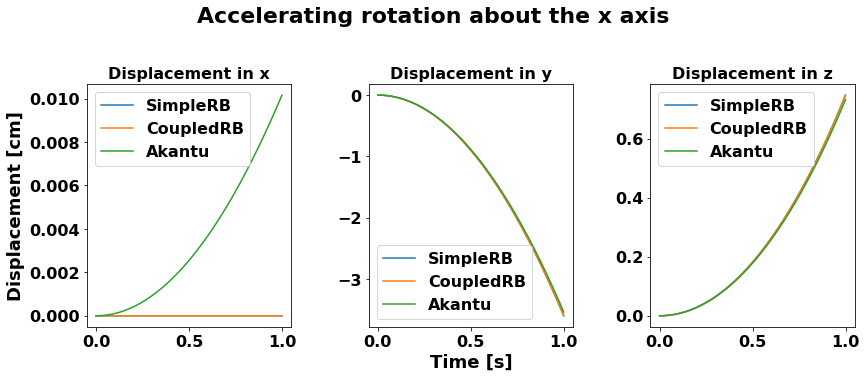

In [6]:
fig, axs = plt.subplots(1, 3)
axes = ['x', 'y', 'z']
for i in range(3):
    axs[i].plot(sim.time_array, sim.total_displacement_vectors[i] * 100, label='SimpleRB')
    axs[i].plot(sim.time_array, cup.total_displacement_vectors[i] * 100, label='CoupledRB')
    axs[i].plot(np.linspace(0,1,116), disps[:, 0, i] * 100, label='Akantu')
    axs[i].legend()
    axs[i].set_title(f'Displacement in {axes[i]}', fontweight='bold')

    if i == 0:
        axs[i].set_ylabel('Displacement [cm]')
        
    if i == 1:
        axs[i].set_xlabel('Time [s]')
    
fig.suptitle('Accelerating rotation about the x axis', fontweight='bold')
fig.set_size_inches(12.5, 5.5)
fig.tight_layout()
fig.show()

In [7]:
# Run SimpleRB for an initial angular acceleration of rb_omega = [1, 0, 0]^T
sim2=SimpleRB('SimpleRB_2', 3, 0.01, 1,
                 mesh_file='../sample_data_files/mesh_files/beam.msh',
                 material_file='../sample_data_files/material_files/steel.dat',
                 num_modes=10,
                 force_path='../sample_data_files/force_files/no_force.txt',
                 eigenmode_path='../sample_data_files/eigenmode_files/rb_modes.csv')
sim2.solve(rb_omega_0=[1, 0, 0])

In [8]:
# Design the initial velocity condition for Akantu. It is given by the cross product of rb_omega x b
b = (sim2.mesh_nodes - sim2.cm)
v_0 = np.cross(np.array([1, 0, 0]), b)

In [9]:
# Set the initial conditions in Akantu and run the simulation

velocity = model.getVelocity()

for row in range(v_0.shape[0]):
    velocity[row] = v_0[row]

for row in range(force.shape[0]):
    force[row] = [0,0,0]
    
for row in range(displacement.shape[0]):
    displacement[row] = [0,0,0]
    
disps2=[]
for i in tqdm(range(0, max_steps + 1)):
    
    if i % 1000 == 0:
        print(velocity.sum(axis=0))
        print(force.sum())
        print(displacement.sum())
    
    model.solveStep()
    if i % 1000 == 0:
        disp=model.getDisplacement()
        disps2.append(disp.copy())

disps2 = np.array(disps2)

  0%|          | 47/115558 [00:00<04:38, 414.44it/s]

[ 0.         -0.07907775 -0.9360063 ]
0.0
0.0


  1%|          | 1117/115558 [00:01<03:03, 622.73it/s]

[ 2.16931949e-04 -7.08715349e-02 -9.36466933e-01]
0.0
-0.008752360063524534


  2%|▏         | 2075/115558 [00:03<03:07, 605.47it/s]

[-4.49759751e-04 -6.30323887e-02 -9.37526902e-01]
0.0
-0.01743935201418867


  3%|▎         | 3107/115558 [00:05<03:14, 576.76it/s]

[ 3.91119992e-04 -5.46427552e-02 -9.37642216e-01]
0.0
-0.02606156937963844


  4%|▎         | 4104/115558 [00:06<03:16, 566.32it/s]

[-4.51205743e-04 -4.67651490e-02 -9.38368421e-01]
0.0
-0.03461742562041348


  4%|▍         | 5112/115558 [00:08<03:03, 602.67it/s]

[-1.00250979e-04 -3.86512546e-02 -9.38655652e-01]
0.0
-0.04310648747352275


  5%|▌         | 6067/115558 [00:10<02:53, 629.62it/s]

[ 2.22316732e-04 -3.03161599e-02 -9.38993364e-01]
0.0
-0.05152887969787656


  6%|▌         | 7101/115558 [00:11<03:00, 602.17it/s]

[-2.08106570e-04 -2.24052829e-02 -9.39327378e-01]
0.0
-0.059882471679912896


  7%|▋         | 8118/115558 [00:13<02:52, 621.53it/s]

[-1.48626468e-04 -1.40963280e-02 -9.39170880e-01]
0.0
-0.0681682802397301


  8%|▊         | 9061/115558 [00:14<03:03, 579.43it/s]

[-7.01223702e-05 -6.29271181e-03 -9.39447147e-01]
0.0
-0.07638436992629316


  9%|▊         | 10071/115558 [00:16<02:48, 626.55it/s]

[ 2.01535865e-05  2.34100647e-03 -9.39542996e-01]
0.0
-0.08453108769353612


 10%|▉         | 11068/115558 [00:18<02:47, 625.53it/s]

[-1.41944196e-04  9.80619755e-03 -9.38832187e-01]
0.0
-0.09260705405768377


 10%|█         | 12080/115558 [00:19<03:11, 541.08it/s]

[ 5.38787103e-05  1.85181282e-02 -9.39770085e-01]
0.0
-0.1006121515369518


 11%|█▏        | 13060/115558 [00:21<03:09, 540.98it/s]

[ 1.78689413e-04  2.67360969e-02 -9.38842027e-01]
0.0
-0.1085459757969609


 12%|█▏        | 14097/115558 [00:23<02:48, 602.25it/s]

[-7.19009931e-07  3.45617784e-02 -9.38631664e-01]
0.0
-0.11640677763826801


 13%|█▎        | 15096/115558 [00:25<02:37, 636.82it/s]

[-3.43881218e-04  4.28851692e-02 -9.38547129e-01]
0.0
-0.12419582133431994


 14%|█▍        | 16084/115558 [00:26<02:35, 638.67it/s]

[ 2.13045283e-04  5.08980184e-02 -9.37802371e-01]
0.0
-0.13191065306760485


 15%|█▍        | 17074/115558 [00:28<02:41, 608.29it/s]

[-1.33727393e-04  5.91031721e-02 -9.37405582e-01]
0.0
-0.13955204119649522


 16%|█▌        | 18090/115558 [00:30<02:57, 548.74it/s]

[-3.62016964e-04  6.70987567e-02 -9.37116197e-01]
0.0
-0.1471186798059101


 17%|█▋        | 19071/115558 [00:32<02:57, 542.25it/s]

[ 4.61888984e-04  7.52858596e-02 -9.36421059e-01]
0.0
-0.15461033507567556


 17%|█▋        | 20126/115558 [00:33<02:45, 576.16it/s]

[-1.86754333e-04  8.34665640e-02 -9.35820996e-01]
0.0
-0.1620264621157652


 18%|█▊        | 21097/115558 [00:35<02:39, 591.39it/s]

[-2.16714729e-04  9.12489810e-02 -9.35060844e-01]
0.0
-0.1693658403610918


 19%|█▉        | 22095/115558 [00:37<03:01, 514.51it/s]

[-3.29323748e-04  9.93405441e-02 -9.34009791e-01]
0.0
-0.17662945512736883


 20%|█▉        | 23076/115558 [00:38<02:22, 647.03it/s]

[-2.20196004e-04  1.07885575e-01 -9.33613530e-01]
0.0
-0.1838147488503239


 21%|██        | 24107/115558 [00:40<02:45, 552.40it/s]

[-1.54484579e-04  1.15355054e-01 -9.32078261e-01]
0.0
-0.1909228699082668


 22%|██▏       | 25111/115558 [00:42<02:36, 576.98it/s]

[-5.19481636e-04  1.23678479e-01 -9.31720617e-01]
0.0
-0.19795248699747958


 23%|██▎       | 26076/115558 [00:44<02:21, 632.88it/s]

[ 4.33028051e-04  1.31747553e-01 -9.30140298e-01]
0.0
-0.20490299590801087


 23%|██▎       | 27070/115558 [00:45<02:21, 625.38it/s]

[-3.10658141e-04  1.39767704e-01 -9.29342447e-01]
0.0
-0.2117744518125626


 24%|██▍       | 28067/115558 [00:47<02:17, 638.27it/s]

[-7.20081214e-04  1.47466083e-01 -9.27711408e-01]
0.0
-0.2185655336899366


 25%|██▌       | 29082/115558 [00:49<02:26, 592.10it/s]

[ 2.17640846e-04  1.55983594e-01 -9.26537785e-01]
0.0
-0.22527685574912226


 26%|██▌       | 30065/115558 [00:50<02:50, 502.71it/s]

[-2.72266681e-04  1.63943357e-01 -9.25149878e-01]
0.0
-0.2319063727195001


 27%|██▋       | 31067/115558 [00:52<02:23, 589.94it/s]

[-3.81261662e-04  1.71737151e-01 -9.23635873e-01]
0.0
-0.23845523062092155


 28%|██▊       | 32107/115558 [00:54<02:04, 671.00it/s]

[ 3.58820216e-05  1.79681670e-01 -9.22178727e-01]
0.0
-0.2449218269767961


 29%|██▊       | 33078/115558 [00:55<02:25, 565.20it/s]

[ 1.62207094e-05  1.88240810e-01 -9.20650280e-01]
0.0
-0.2513058298115851


 29%|██▉       | 34063/115558 [00:57<02:21, 575.35it/s]

[-3.94017486e-04  1.95594935e-01 -9.18801641e-01]
0.0
-0.2576074733353657


 30%|███       | 35129/115558 [00:59<02:08, 626.50it/s]

[ 5.94200708e-05  2.03680567e-01 -9.17060991e-01]
0.0
-0.26382518823440293


 31%|███       | 36085/115558 [01:00<02:12, 601.15it/s]

[-1.71611968e-04  2.12247410e-01 -9.15538455e-01]
0.0
-0.26995965536765


 32%|███▏      | 37077/115558 [01:02<02:08, 611.56it/s]

[-4.63856043e-04  2.19306444e-01 -9.13224646e-01]
0.0
-0.2760091510370941


 33%|███▎      | 38112/115558 [01:04<02:15, 570.17it/s]

[-2.82115648e-04  2.27849557e-01 -9.11874155e-01]
0.0
-0.28197471068923363


 34%|███▍      | 39113/115558 [01:05<02:01, 627.02it/s]

[-3.86454676e-04  2.35180938e-01 -9.09350684e-01]
0.0
-0.2878544418185882


 35%|███▍      | 40088/115558 [01:07<02:00, 625.04it/s]

[-1.00496047e-05  2.43421178e-01 -9.07716109e-01]
0.0
-0.2936487569016393


 36%|███▌      | 41089/115558 [01:09<01:59, 621.44it/s]

[-7.61967954e-04  2.50974134e-01 -9.05445321e-01]
0.0
-0.2993573952158002


 36%|███▋      | 42116/115558 [01:10<02:00, 608.87it/s]

[-1.90156257e-05  2.58777342e-01 -9.03197315e-01]
0.0
-0.30497879655670346


 37%|███▋      | 43078/115558 [01:12<02:18, 525.09it/s]

[-4.36120532e-04  2.66877529e-01 -9.00929981e-01]
0.0
-0.3105141245589138


 38%|███▊      | 44070/115558 [01:14<01:58, 605.52it/s]

[-6.32143697e-04  2.74435548e-01 -8.98842871e-01]
0.0
-0.31596139910332965


 39%|███▉      | 45047/115558 [01:15<02:47, 421.17it/s]

[-2.30629456e-04  2.81968287e-01 -8.95984275e-01]
0.0
-0.3213216029016408


 40%|███▉      | 46071/115558 [01:18<02:01, 573.46it/s]

[-7.67339039e-04  2.90181052e-01 -8.94025490e-01]
0.0
-0.32659308549212085


 41%|████      | 47102/115558 [01:20<02:07, 537.91it/s]

[-4.36465753e-05  2.97481389e-01 -8.91312359e-01]
0.0
-0.331776469969455


 42%|████▏     | 48071/115558 [01:21<02:03, 545.49it/s]

[-5.74531219e-04  3.05332626e-01 -8.88463651e-01]
0.0
-0.3368709863900392


 42%|████▏     | 49096/115558 [01:23<01:58, 559.29it/s]

[-1.32539885e-04  3.13194499e-01 -8.86176815e-01]
0.0
-0.3418755580018953


 43%|████▎     | 50076/115558 [01:25<02:10, 501.49it/s]

[-1.60473162e-04  3.20720069e-01 -8.83149522e-01]
0.0
-0.3467914920850461


 44%|████▍     | 51112/115558 [01:27<01:39, 649.92it/s]

[-8.24790285e-04  3.28547952e-01 -8.80236646e-01]
0.0
-0.35161640808339456


 45%|████▌     | 52125/115558 [01:28<01:36, 655.68it/s]

[-2.11545749e-04  3.35806167e-01 -8.77515783e-01]
0.0
-0.35635160132622445


 46%|████▌     | 53070/115558 [01:30<01:39, 626.33it/s]

[-3.65040753e-04  3.43824313e-01 -8.74607891e-01]
0.0
-0.36099569339248916


 47%|████▋     | 54094/115558 [01:31<01:57, 524.38it/s]

[-3.15330910e-04  3.51105986e-01 -8.71521815e-01]
0.0
-0.36554886131578


 48%|████▊     | 55075/115558 [01:33<01:51, 541.15it/s]

[-1.68685559e-04  3.58851297e-01 -8.68432629e-01]
0.0
-0.3700105572893406


 49%|████▊     | 56064/115558 [01:35<01:50, 537.24it/s]

[-3.03051673e-04  3.66302912e-01 -8.65523758e-01]
0.0
-0.37438017948591806


 49%|████▉     | 57058/115558 [01:37<01:54, 510.01it/s]

[-5.44940555e-04  3.73655044e-01 -8.62186942e-01]
0.0
-0.3786585019627111


 50%|█████     | 58078/115558 [01:39<01:47, 534.91it/s]

[-4.73176780e-04  3.81090796e-01 -8.58586012e-01]
0.0
-0.38284329999345346


 51%|█████     | 59052/115558 [01:41<01:36, 583.11it/s]


[-6.93890116e-04  3.88657771e-01 -8.55859270e-01]
0.0
-0.3869363098918086


KeyboardInterrupt: 

In [ ]:
# Format the plot and plot the results
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"


fig, axs = plt.subplots(1, 3)
axes = ['x', 'y', 'z']
for i in range(3):
    axs[i].plot(sim2.time_array, sim2.total_displacement_vectors[i] * 100, label='SimpleRB')
    axs[i].plot(np.linspace(0,1,116), disps2[:, 0, i] * 100, label='Akantu')
    axs[i].legend()
    axs[i].set_title(f'Displacement in {axes[i]}', fontweight='bold')

    if i == 0:
        axs[i].set_ylabel('Displacement [cm]')
        
    if i == 1:
        axs[i].set_xlabel('Time [s]')
    
fig.suptitle('Constant rotation about the x axis', fontweight='bold')
fig.set_size_inches(12.5, 5.5)
fig.tight_layout()
fig.show()